In [1]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
import os
import torch
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import numpy as np
import cv2
from particle_detection.autoencoder.model import create_autoencoder
from particle_detection.data.dataset import create_dataloaders

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [4]:
data_dir = "/home/blah-buttery/nanoparticles/images/normal"
#image_size = (256, 256)
image_size = (1024, 1024)
batch_size = 8

train_loader, test_loader = create_dataloaders(data_dir=data_dir, image_size=image_size, batch_size=batch_size)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):  # Set in_channels=1 for grayscale
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 1024 -> 512
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Add BatchNorm
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 512 -> 256
            nn.ReLU(),
            nn.BatchNorm2d(128),  # Add BatchNorm
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256 -> 128
            nn.AdaptiveAvgPool2d((8, 8)),  # Reduce spatial dimensions further
            nn.ReLU(),
            nn.BatchNorm2d(256)   # Add BatchNorm
        )
        
        # Latent space
        self.flattened_dim = 256 * 8 * 8  # Adjusted for adaptive pooling
        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, self.flattened_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64 -> 128
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128 -> 256
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),  # 256 -> 512
            nn.ReLU(),
            nn.ConvTranspose2d(4, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # 512 -> 1024
            nn.Sigmoid()
        )


    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + std * epsilon
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, debug=False):
        if torch.isnan(x).any():
            print("[ERROR] NaN detected in input!")
            raise ValueError("NaN detected in input tensor.")
    
        # Encode
        encoded = self.encoder(x)
    
        if torch.isnan(encoded).any():
            print("[ERROR] NaN detected in encoded tensor!")
            raise ValueError("NaN detected in encoded tensor.")
    
        encoded_flat = encoded.view(encoded.size(0), -1)
        
        # Latent variables
        mu = self.fc_mu(encoded_flat)
        logvar = self.fc_logvar(encoded_flat)
        logvar = torch.clamp(logvar, min=-10, max=10)  # Avoid too large/small values

    
        if torch.isnan(mu).any() or torch.isnan(logvar).any():
            print("[ERROR] NaN detected in latent variables!")
            raise ValueError("NaN detected in latent space.")
    
        z = self.reparameterize(mu, logvar)
    
        # Decode
        decoded_flat = self.fc_decoder(z)
        decoded = decoded_flat.view(-1, 256, 8, 8)
        x_reconstructed = self.decoder(decoded)
    
        if torch.isnan(x_reconstructed).any():
            print("[ERROR] NaN detected in reconstructed output!")
            raise ValueError("NaN detected in reconstructed tensor.")
        #print(f"Final reconstructed shape: {x_reconstructed.shape}")

    
        return x_reconstructed, mu, logvar
    '''
    def forward(self, x, debug=False):
        if debug:
            print(f"Input shape: {x.shape}")
        
        # Encode
        encoded = self.encoder(x)
        if debug:
            print(f"Encoded shape: {encoded.shape}")
        encoded_flat = encoded.view(encoded.size(0), -1)
        
        # Latent variables
        mu = self.fc_mu(encoded_flat)
        logvar = self.fc_logvar(encoded_flat)
        z = self.reparameterize(mu, logvar)

        # Decode
        decoded_flat = self.fc_decoder(z)
        decoded = decoded_flat.view(-1, 256, 8, 8)  # Adjusted to match adaptive pooling
        if debug:
            print(f"Decoded (before upsampling) shape: {decoded.shape}")
        x_reconstructed = self.decoder(decoded)
        if debug:
            print(f"Reconstructed shape: {x_reconstructed.shape}")

        # Ensure reconstruction matches input size
        x_reconstructed = F.interpolate(x_reconstructed, size=x.shape[2:], mode="bilinear", align_corners=False)
        if debug:
            print(f"Final reconstructed shape (after interpolation): {x_reconstructed.shape}")

        return x_reconstructed, mu, logvar
    '''

# Loss function for VAE
'''
def vae_loss(recon_x, x, mu, logvar):
    """
    Computes the VAE loss as the sum of reconstruction loss and KL divergence.
    :param recon_x: Reconstructed input.
    :param x: Original input.
    :param mu: Mean of the latent distribution.
    :param logvar: Log variance of the latent distribution.
    """
    # Reconstruction loss
    recon_loss = F.l1_loss(recon_x, x, reduction='sum') / x.size(0)
    
    # KL divergence
    #kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp().clamp(min=1e-8))

    return recon_loss + kl_div
'''
def vae_loss(recon_x, x, mu, logvar, beta=0.1):  # Reduce KL effect
    recon_loss = F.l1_loss(recon_x, x, reduction='sum') / x.size(0)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div
def create_vae(in_channels=1):
    """
    Creates and returns a Variational Autoencoder (VAE) instance.
    """
    model = VAE(in_channels=in_channels)
    def weights_init(m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    model.apply(weights_init)
    return model


In [17]:
# 1024,1024 model

import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):  # Set in_channels=1 for grayscale
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 1024 -> 512
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Add BatchNorm
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 512 -> 256
            nn.ReLU(),
            nn.BatchNorm2d(128),  # Add BatchNorm
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256 -> 128
            nn.AdaptiveAvgPool2d((8, 8)),  # Reduce spatial dimensions further
            nn.ReLU(),
            nn.BatchNorm2d(256)   # Add BatchNorm
        )

        # Latent space
        self.flattened_dim = 256 * 8 * 8  # Adjusted for adaptive pooling
        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, self.flattened_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64 -> 128
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128 -> 256
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),  # 256 -> 512
            nn.ReLU(),
            nn.ConvTranspose2d(4, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # 512 -> 1024
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + std * epsilon
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        encoded_flat = encoded.view(encoded.size(0), -1)

        # Latent variables
        mu = self.fc_mu(encoded_flat)
        logvar = self.fc_logvar(encoded_flat)
        logvar = torch.clamp(logvar, min=-10, max=10)  # Avoid too large/small values

        z = self.reparameterize(mu, logvar)

        # Decode
        decoded_flat = self.fc_decoder(z)
        decoded = decoded_flat.view(-1, 256, 8, 8)
        x_reconstructed = self.decoder(decoded)

        return x_reconstructed, mu, logvar

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar, beta=0.1, kl_weight=1.0):
    """
    Computes the VAE loss with weighted KL divergence.
    :param recon_x: Reconstructed input.
    :param x: Original input.
    :param mu: Mean of the latent distribution.
    :param logvar: Log variance of the latent distribution.
    :param beta: Fixed scaling factor for the KL divergence (default: 0.1).
    :param kl_weight: Dynamic weight for the KL divergence.
    """
    # Reconstruction loss
    recon_loss = F.l1_loss(recon_x, x, reduction='sum') / x.size(0)

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    return recon_loss + (beta * kl_weight) * kl_div

def create_vae(in_channels=1):
    """
    Creates and returns a Variational Autoencoder (VAE) instance.
    """
    model = VAE(in_channels=in_channels)

    def weights_init(m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    model.apply(weights_init)
    return model

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):  # Set in_channels=1 for grayscale
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 1024 -> 512
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 512 -> 256
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256 -> 128
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 128 -> 64
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.AdaptiveAvgPool2d((4, 4))  # Reduce spatial dimensions further
        )

        # Latent space
        self.flattened_dim = 1024 * 4 * 4
        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, self.flattened_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, output_padding=0),  # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=0),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),  # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),  # 64 -> 128
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, output_padding=0),  # 128 -> 256
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1, output_padding=0),  # 256 -> 512
            nn.ReLU(),
            nn.ConvTranspose2d(8, in_channels, kernel_size=4, stride=2, padding=1, output_padding=0),  # 512 -> 1024
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + std * epsilon
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        encoded_flat = encoded.view(encoded.size(0), -1)

        # Latent variables
        mu = self.fc_mu(encoded_flat)
        logvar = self.fc_logvar(encoded_flat)
        logvar = torch.clamp(logvar, min=-10, max=10)  # Avoid too large/small values

        z = self.reparameterize(mu, logvar)

        # Decode
        decoded_flat = self.fc_decoder(z)
        decoded = decoded_flat.view(-1, 1024, 4, 4)
        x_reconstructed = self.decoder(decoded)

        return x_reconstructed, mu, logvar

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar, beta=0.1, kl_weight=1.0):
    """
    Computes the VAE loss with weighted KL divergence.
    """
    # Reconstruction loss
    recon_loss = F.l1_loss(recon_x, x, reduction='sum') / x.size(0)

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    # Total loss
    return recon_loss + (beta * kl_weight) * kl_div

# Create and initialize the model
def create_vae(in_channels=1):
    model = VAE(in_channels=in_channels)

    def weights_init(m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    model.apply(weights_init)
    return model


In [5]:
# 256,256 model

import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=128):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 256 -> 128
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128 -> 64
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d((4, 4))  # Ensure a fixed 4x4 spatial size
        )

        # Latent space
        self.flattened_dim = 512 * 4 * 4
        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, self.flattened_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4 -> 8
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32 -> 64
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 64 -> 128
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, in_channels, kernel_size=4, stride=2, padding=1),  # 128 -> 256
            nn.Sigmoid()  # Normalize to [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        encoded_flat = encoded.view(encoded.size(0), -1)

        # Latent variables
        mu = self.fc_mu(encoded_flat)
        logvar = self.fc_logvar(encoded_flat)
        z = self.reparameterize(mu, logvar)

        # Decode
        decoded_flat = self.fc_decoder(z)
        decoded = decoded_flat.view(-1, 512, 4, 4)
        x_reconstructed = self.decoder(decoded)

        return x_reconstructed, mu, logvar



# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar, beta=0.1, kl_weight=1.0):
    # Resize reconstructed output to match input size
    if recon_x.shape != x.shape:
        recon_x = F.interpolate(recon_x, size=x.shape[2:], mode="bilinear", align_corners=False)

    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + (beta * kl_weight) * kl_div



def create_vae(in_channels=1):
    """
    Creates and returns a Variational Autoencoder (VAE) instance.
    """
    model = VAE(in_channels=in_channels)

    def weights_init(m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    model.apply(weights_init)
    return model

In [6]:
for batch in train_loader:
    print(batch.shape)
    break


torch.Size([8, 3, 1024, 1024])


In [14]:
from tqdm import tqdm  # Import tqdm for progress bar

def train_vae(model, train_loader, optimizer, num_epochs, accumulation_steps=1, device="cuda", debug_mode=False):
    model.to(device)
    model.train()

    if debug_mode:
        torch.autograd.set_detect_anomaly(True)
        print("[DEBUG] Anomaly detection enabled.")
    else:
        print("[INFO] Running in normal mode (anomaly detection OFF).")

    training_losses = []  # Keep this for plotting loss later
    clamp_value = 10  # Clamp value for logvar stabilization

    for epoch in range(num_epochs):
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        optimizer.zero_grad()  # Move this outside to avoid resetting it per batch

        for i, batch in enumerate(progress_bar):
            batch = batch.to(device)

            # Forward pass
            reconstructed, mu, logvar = model(batch)

            # Clamp logvar to stabilize KL divergence
            logvar = torch.clamp(logvar, min=-clamp_value, max=clamp_value)

            loss = vae_loss(reconstructed, batch, mu, logvar)

            # Only scale the loss if accumulation is greater than 1
            if accumulation_steps > 1:
                loss = loss / accumulation_steps  

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Perform optimizer step every `accumulation_steps` batches
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            # Accumulate loss
            train_loss += loss.item() * (accumulation_steps if accumulation_steps > 1 else 1)

            # Update progress bar
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_loss = train_loss / len(train_loader.dataset)
        training_losses.append(avg_loss)  # Keep loss tracking
        print(f"[INFO] Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

    print("[INFO] Training complete!")
    
    return training_losses  # Return for loss visualization


In [23]:
from tqdm import tqdm  # Import tqdm for progress bar
from torch.optim.lr_scheduler import StepLR

def train_vae(model, train_loader, optimizer, num_epochs, kl_weight=1.0, device="cuda", debug_mode=False):
    model.to(device)
    model.train()

    if debug_mode:
        torch.autograd.set_detect_anomaly(True)
        print("[DEBUG] Anomaly detection enabled.")
    else:
        print("[INFO] Running in normal mode (anomaly detection OFF).")

    training_losses = []  # Keep this for plotting loss later
    clamp_value = 10  # Clamp value for logvar stabilization

    for epoch in range(num_epochs):
        #kl_weight = min(1.0, epoch / (num_epochs // 2))  # Gradually increase KL weight
        #kl_weight = min(kl_weight, epoch / anneal_epochs)
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        optimizer.zero_grad()  # Move this outside to avoid resetting it per batch

        for i, batch in enumerate(progress_bar):
            batch = batch.to(device)

            # Forward pass
            reconstructed, mu, logvar = model(batch)
            logvar = torch.clamp(logvar, min=-clamp_value, max=clamp_value) # Clamp logvar to stabilize KL divergence
            loss = vae_loss(reconstructed, batch, mu, logvar, beta=0.1, kl_weight=kl_weight) # Compute loss with dynamic KL weight

            # Only scale the loss if accumulation is greater than 1
            #if accumulation_steps > 1:
                #loss = loss / accumulation_steps  

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            optimizer.zero_grad()

            # Accumulate loss
            train_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", kl_weight=f"{kl_weight:.4f}")

        avg_loss = train_loss / len(train_loader.dataset)
        training_losses.append(avg_loss)  # Keep loss tracking
        scheduler.step()
        print(f"[INFO] Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, KL Weight: {kl_weight:.4f}")

    print("[INFO] Training complete!")
    
    return training_losses  # Return for loss visualization

In [51]:
# Define model, optimizer, and dataloader
vae = VAE(in_channels=3, latent_dim=128)
vae = nn.DataParallel(vae).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)
#optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, step_size=3, gamma=0.3)  # Reduce LR by half every 5 epochs

# Train the model
losses =train_vae(model=vae, train_loader=train_loader, optimizer=optimizer, num_epochs=20, kl_weight=0.1, device="cuda", debug_mode="False")

[DEBUG] Anomaly detection enabled.


Epoch 1/20: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it, kl_weight=0.1000, loss=547436.9375]


[INFO] Epoch [1/20], Avg Loss: 68429.6172, KL Weight: 0.1000


Epoch 2/20: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it, kl_weight=0.1000, loss=538755.6875]


[INFO] Epoch [2/20], Avg Loss: 67344.4609, KL Weight: 0.1000


Epoch 3/20: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it, kl_weight=0.1000, loss=608545.6250]


[INFO] Epoch [3/20], Avg Loss: 76068.2031, KL Weight: 0.1000


Epoch 4/20: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it, kl_weight=0.1000, loss=595748.6250]


[INFO] Epoch [4/20], Avg Loss: 74468.5781, KL Weight: 0.1000


Epoch 5/20: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it, kl_weight=0.1000, loss=606602.8750]


[INFO] Epoch [5/20], Avg Loss: 75825.3594, KL Weight: 0.1000


Epoch 6/20: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it, kl_weight=0.1000, loss=565842.0000]


[INFO] Epoch [6/20], Avg Loss: 70730.2500, KL Weight: 0.1000


Epoch 7/20: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it, kl_weight=0.1000, loss=502809.4062]


[INFO] Epoch [7/20], Avg Loss: 62851.1758, KL Weight: 0.1000


Epoch 8/20: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it, kl_weight=0.1000, loss=731374.0000]


[INFO] Epoch [8/20], Avg Loss: 91421.7500, KL Weight: 0.1000


Epoch 9/20: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it, kl_weight=0.1000, loss=753773.0625]


[INFO] Epoch [9/20], Avg Loss: 94221.6328, KL Weight: 0.1000


Epoch 10/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it, kl_weight=0.1000, loss=648013.1875]


[INFO] Epoch [10/20], Avg Loss: 81001.6484, KL Weight: 0.1000


Epoch 11/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it, kl_weight=0.1000, loss=606149.3125]


[INFO] Epoch [11/20], Avg Loss: 75768.6641, KL Weight: 0.1000


Epoch 12/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it, kl_weight=0.1000, loss=622303.0000]


[INFO] Epoch [12/20], Avg Loss: 77787.8750, KL Weight: 0.1000


Epoch 13/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it, kl_weight=0.1000, loss=666216.1875]


[INFO] Epoch [13/20], Avg Loss: 83277.0234, KL Weight: 0.1000


Epoch 14/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it, kl_weight=0.1000, loss=503457.5938]


[INFO] Epoch [14/20], Avg Loss: 62932.1992, KL Weight: 0.1000


Epoch 15/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it, kl_weight=0.1000, loss=601634.7500]


[INFO] Epoch [15/20], Avg Loss: 75204.3438, KL Weight: 0.1000


Epoch 16/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it, kl_weight=0.1000, loss=495260.2812]


[INFO] Epoch [16/20], Avg Loss: 61907.5352, KL Weight: 0.1000


Epoch 17/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it, kl_weight=0.1000, loss=571237.5000]


[INFO] Epoch [17/20], Avg Loss: 71404.6875, KL Weight: 0.1000


Epoch 18/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it, kl_weight=0.1000, loss=508977.7812]


[INFO] Epoch [18/20], Avg Loss: 63622.2227, KL Weight: 0.1000


Epoch 19/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it, kl_weight=0.1000, loss=586024.5000]


[INFO] Epoch [19/20], Avg Loss: 73253.0625, KL Weight: 0.1000


Epoch 20/20: 100%|█████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it, kl_weight=0.1000, loss=561743.1250]

[INFO] Epoch [20/20], Avg Loss: 70217.8906, KL Weight: 0.1000
[INFO] Training complete!


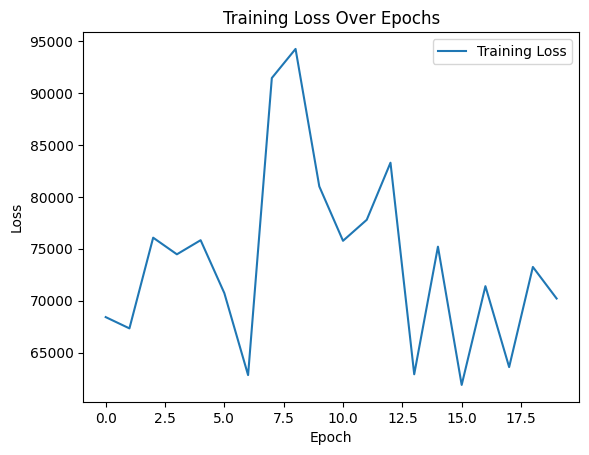

In [52]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Over Epochs")
plt.show()


Original image shape: torch.Size([3, 1024, 1024])
Reconstructed image shape: torch.Size([3, 1024, 1024])


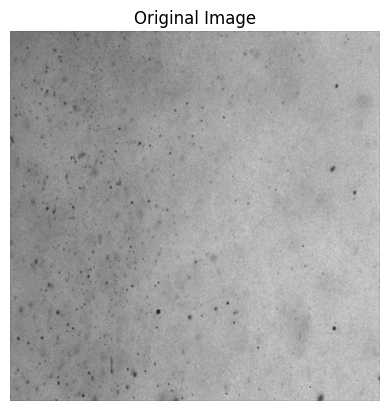

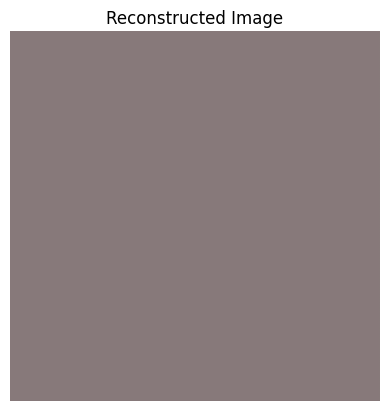

In [53]:
import matplotlib.pyplot as plt
import torch

# Forward pass sample_img through our trained model
sample_img = next(iter(test_loader))  # Get a batch of test images
sample_img = sample_img.to(device)

with torch.no_grad():
    # Unpack the tuple returned by the model
    reconstructed_img, _, _ = vae(sample_img)

# Handling batch dimensions to take the first image
sample_img = sample_img[0, :, :, :]  # Take the first image in the batch
print(f"Original image shape: {sample_img.shape}")
reconstructed_img = reconstructed_img[0, :, :, :]  # Match the shape for reconstruction
print(f"Reconstructed image shape: {reconstructed_img.shape}")

# Clamp values to ensure valid image range
sample_img = torch.clamp(sample_img, min=0, max=1)
reconstructed_img = torch.clamp(reconstructed_img, min=0, max=1)

# Function to display images (works for both grayscale and RGB)
def display_image(tensor, image_type="grayscale", title="Image"):
    """
    Displays an image from a PyTorch tensor.

    Args:
    - tensor (torch.Tensor): The image tensor (C, H, W).
    - image_type (str): "grayscale" for single-channel, "rgb" for multi-channel.
    - title (str): Title of the displayed image.
    """
    tensor = tensor.cpu().detach().numpy()

    if image_type == "grayscale":
        plt.imshow(tensor.squeeze(), cmap="gray")
    elif image_type == "rgb":
        # Transpose to HWC for RGB
        tensor = tensor.transpose(1, 2, 0)
        plt.imshow(tensor)
    else:
        raise ValueError(f"Invalid image_type: {image_type}. Use 'grayscale' or 'rgb'.")

    plt.axis("off")
    plt.title(title)
    plt.show()

# Display original and reconstructed images
image_type = "rgb"  # Change to "rgb" for RGB images
display_image(sample_img, image_type=image_type, title="Original Image")
display_image(reconstructed_img, image_type=image_type, title="Reconstructed Image")

torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])


TypeError: Invalid shape (3, 1024, 1024) for image data

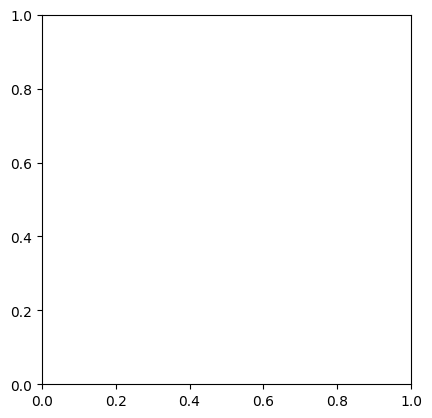

In [10]:
#only for grayscale 

import matplotlib.pyplot as plt
import torch

# Forward pass sample_img through our trained model
sample_img = next(iter(test_loader))  # Get a batch of test images
sample_img = sample_img.to(device)

with torch.no_grad():
    # Unpack the tuple returned by the model
    reconstructed_img, _, _ = vae(sample_img)

# Handling batch dimensions to take the first image
sample_img = sample_img[0, :, :, :]  # Take the first image in the batch
print(sample_img.shape)
reconstructed_img = reconstructed_img[0, :, :, :]  # Match the shape for reconstruction
print(reconstructed_img.shape)

# Clamp values to ensure valid image range
sample_img = torch.clamp(sample_img, min=0, max=1)
reconstructed_img = torch.clamp(reconstructed_img, min=0, max=1)

# Function to display images
def display_image(tensor, title="Image"):
    tensor = tensor.cpu().detach().numpy()
    plt.imshow(tensor.squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Display original and reconstructed images
display_image(sample_img, title="Original Image")
display_image(reconstructed_img, title="Reconstructed Image")


Type of reconstructed_img: <class 'torch.Tensor'>
Shape of reconstructed_img: torch.Size([3, 1, 256, 256])


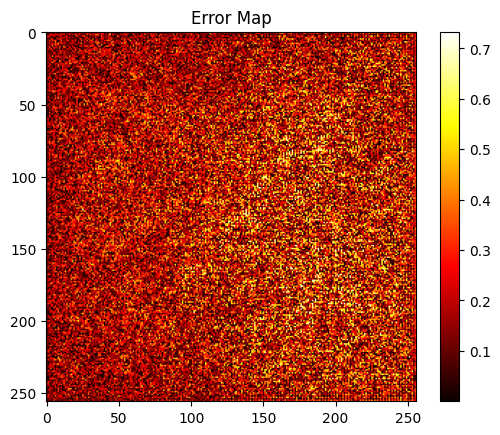

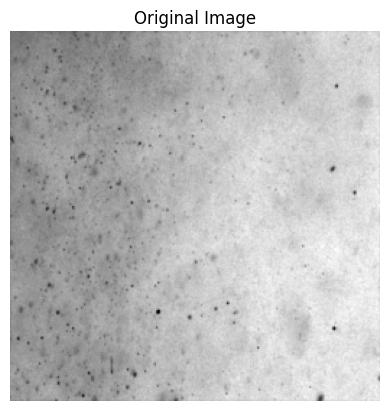

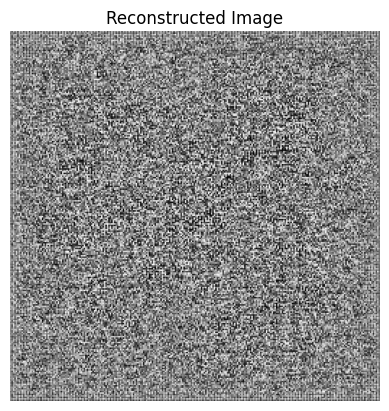

In [11]:
import matplotlib.pyplot as plt

sample_img = next(iter(test_loader))
sample_img = sample_img.to(device)

# Forward pass sample_img through our trained model
with torch.no_grad():
    # Unpack the tuple returned by the model
    reconstructed_img, _, _ = vae(sample_img)  # Unpack reconstructed_img, mu, logvar

# Debugging: Ensure `reconstructed_img` is valid
print(f"Type of reconstructed_img: {type(reconstructed_img)}")
print(f"Shape of reconstructed_img: {reconstructed_img.shape if isinstance(reconstructed_img, torch.Tensor) else None}")

# Ensure `reconstructed_img` is clamped correctly
if isinstance(reconstructed_img, torch.Tensor):
    reconstructed_img = torch.clamp(reconstructed_img, min=0, max=1)
else:
    raise ValueError("Expected `reconstructed_img` to be a Tensor but got None or invalid type.")

# Calculate error map
error_map = torch.abs(sample_img - reconstructed_img).mean(dim=1).cpu().numpy()
error_map_image = error_map[0]

# Display error map
plt.imshow(error_map_image, cmap="hot")
plt.colorbar()
plt.title("Error Map")
plt.show()

# Function to display images
def display_image(tensor, title="Image"):
    img = tensor.cpu().detach().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Display original and reconstructed images
display_image(sample_img[0], title="Original Image")
display_image(reconstructed_img[0], title="Reconstructed Image")


In [11]:
import torch.autograd.profiler as profiler

def profile_train_vae(model, train_loader, optimizer, num_epochs=1, device="cuda"):
    model.to(device)
    model.train()
    print("[INFO] Profiling Training Performance...")

    with profiler.profile(
        use_cuda=True,  # Older PyTorch versions use this instead of 'activities'
        record_shapes=True, 
        profile_memory=True
    ) as prof:

        for epoch in range(num_epochs):
            train_loss = 0.0

            for batch in train_loader:
                batch = batch.to(device, non_blocking=True)

                optimizer.zero_grad()
                reconstructed, mu, logvar = model(batch)

                loss = vae_loss(reconstructed, batch, mu, logvar)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

        print(f"[INFO] Profiling Complete. Avg Loss: {train_loss:.4f}")

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))  # Show top CUDA operations

In [12]:
vae = VAE(in_channels=1, latent_dim=128)
vae = nn.DataParallel(vae).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
profile_train_vae(vae, train_loader, optimizer, num_epochs=1)

[INFO] Profiling Training Performance...


/tmp/ipykernel_10262/3327950434.py:8: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with profiler.profile(


[INFO] Profiling Complete. Avg Loss: 1300723.7109
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   DataParallel.forward         1.19%      23.540ms        41.71%     823.831ms     102.979ms      21.397ms         1.08%     823.871ms     102.984ms     

In [39]:
import torch
import numpy as np

# Function to extract latent representations
def extract_latent_space(model, dataloader, device="cuda"):
    latent_vectors = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch.to(device)
            _, mu, _ = model(inputs)  # Forward pass through VAE to get `mu`
            latent_vectors.append(mu.cpu().numpy())

    # Concatenate all latent vectors into a single array
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    return latent_vectors


In [44]:
from sklearn.mixture import GaussianMixture

# Extract latent representations
latent_vectors = extract_latent_space(vae, test_loader)

# Apply GMM clustering
n_components = 3  # Number of clusters
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(latent_vectors)
cluster_labels = gmm.predict(latent_vectors)
#print(cluster_labels.shape)
# Print results
print(f"Cluster Labels: {cluster_labels}")


(3,)
Cluster Labels: [1 0 2]


In [41]:
def visualize_clusters_on_image(image_batch, cluster_labels_grid):
    """
    Visualize clusters directly on the spatial grid of the image.
    """
    # Select the first image and its cluster labels
    single_image = image_batch[0]  # Shape: [C, H, W]
    single_cluster_labels = cluster_labels_grid[0]  # Shape: [H, W]

    # Visualize the image and clusters
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    image_np = single_image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # Normalize
    plt.imshow(image_np.squeeze(), cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Cluster Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(single_cluster_labels, cmap="viridis")
    plt.title("Cluster Visualization")
    plt.colorbar(label="Cluster")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [42]:
# Step 3: Map clusters back to spatial grid
# Assuming the latent space corresponds spatially to the input, reshape cluster labels
# Example: Reshape [B, latent_dim] into [B, H, W]
cluster_labels_grid = cluster_labels.reshape(-1, 256, 256)  # Adjust size as needed

# Step 4: Visualize the clusters
visualize_clusters_on_image(sample_img, cluster_labels_grid)

ValueError: cannot reshape array of size 3 into shape (256,256)

In [57]:
def extract_latent_space_as_spatial(model, dataloader, device):
    """
    Extract spatially aware latent representations from the encoder.
    Args:
        model: Trained VAE model.
        dataloader: Dataloader for the test set.
        device: Device to perform computations on.
    Returns:
        torch.Tensor: Spatial latent representations of shape [B, C, H, W].
    """
    model.eval()
    latent_spatial = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            encoded = model.module.encoder(batch)  # Get spatially aware latent features
            latent_spatial.append(encoded.cpu())
    return torch.cat(latent_spatial, dim=0)  # Shape [B, C, H, W]

In [58]:
from sklearn.mixture import GaussianMixture

def apply_gmm_clustering(latent_spatial, n_components=3):
    """
    Apply GMM clustering on spatially aware latent features.
    Args:
        latent_spatial (torch.Tensor): Spatial latent features of shape [B, C, H, W].
        n_components (int): Number of clusters.
    Returns:
        np.ndarray: Cluster labels reshaped into spatial grid [B, H, W].
    """
    B, C, H, W = latent_spatial.shape
    
    # Flatten spatial dimensions for clustering
    latent_vectors_flat = latent_spatial.permute(0, 2, 3, 1).reshape(-1, C)  # Shape [B*H*W, C]
    
    # Apply GMM clustering
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(latent_vectors_flat)
    cluster_labels_flat = gmm.predict(latent_vectors_flat)  # Shape [B*H*W]
    
    # Reshape cluster labels back to spatial dimensions
    cluster_labels_grid = cluster_labels_flat.reshape(B, H, W)  # Shape [B, H, W]
    
    return cluster_labels_grid


In [59]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_clusters_on_image(image_batch, cluster_labels_grid):
    """
    Visualize clusters on the spatial grid of the image.
    Args:
        image_batch (torch.Tensor): Batch of images, shape [B, C, H, W].
        cluster_labels_grid (np.ndarray): Cluster labels, shape [B, H, W].
    Returns:
        None
    """
    # Select the first image and its cluster labels
    single_image = image_batch[0]  # Shape: [C, H, W]
    single_cluster_labels = cluster_labels_grid[0]  # Shape: [H, W]

    # Visualize the image and clusters
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    image_np = single_image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # Normalize if needed
    plt.imshow(image_np.squeeze(), cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Cluster Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(single_cluster_labels, cmap="viridis")
    plt.title("Cluster Visualization")
    plt.colorbar(label="Cluster")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


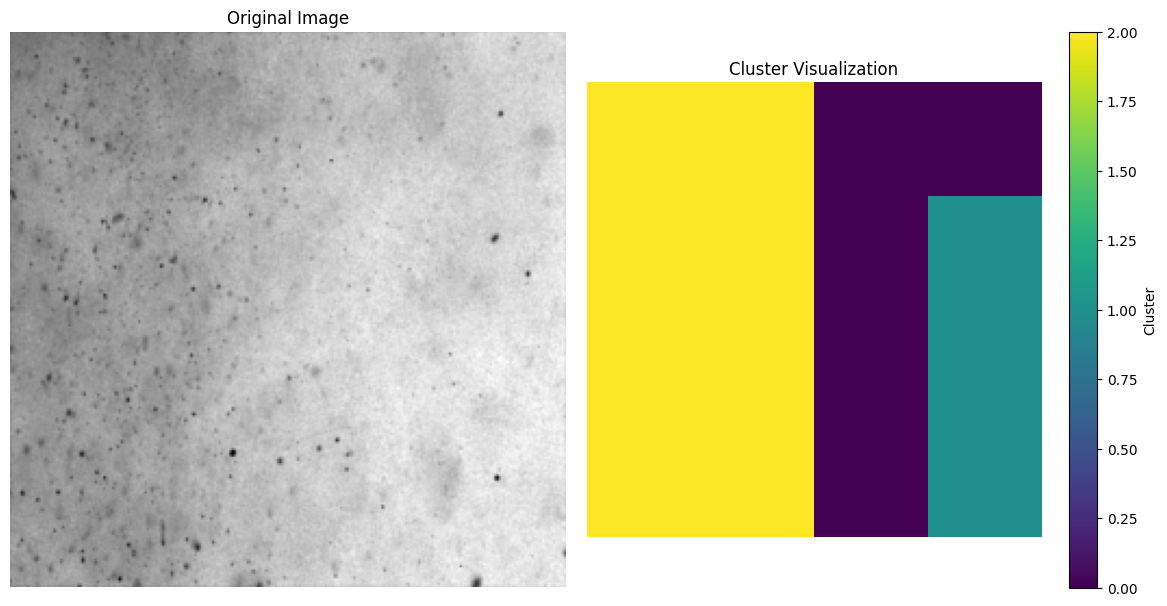

In [66]:
# Extract spatial latent representations
latent_spatial = extract_latent_space_as_spatial(vae, test_loader, device)  # Shape [B, C, H, W]

# Apply GMM clustering
n_components = 3  # Set the number of clusters
cluster_labels_grid = apply_gmm_clustering(latent_spatial, n_components=n_components)  # Shape [B, H, W]

# Visualize the clusters on the first image
sample_img = next(iter(test_loader))  # Get a batch of images
sample_img = sample_img.to(device)  # Move to device
visualize_clusters_on_image(sample_img, cluster_labels_grid)

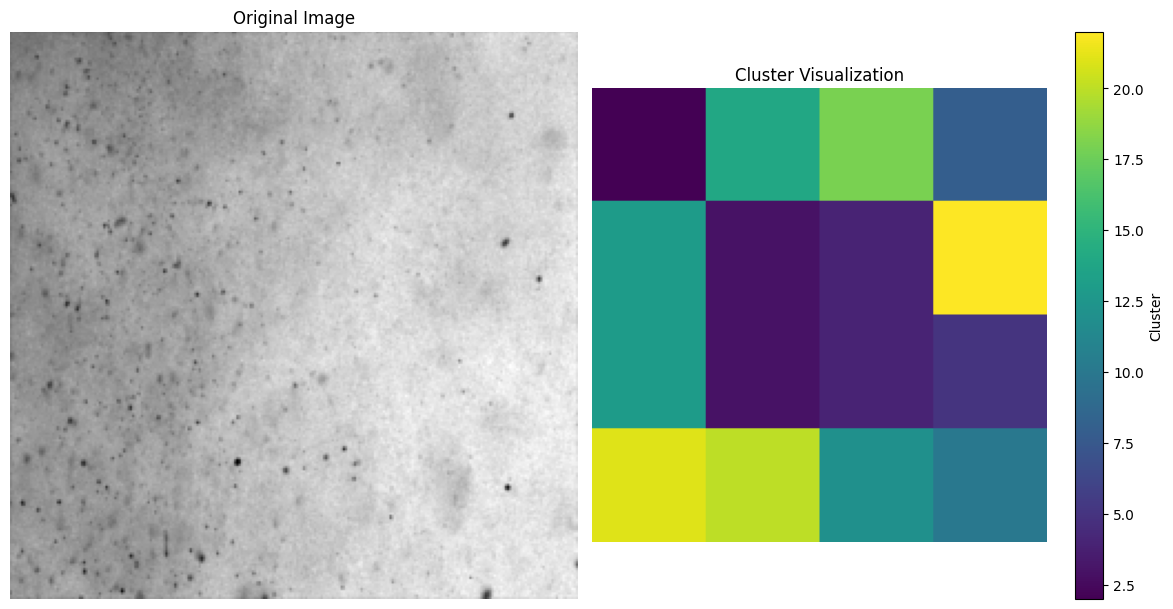

In [69]:
import torch
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

def extract_latent_space_as_spatial(model, dataloader, device):
    """
    Extract spatially aware latent representations from the encoder.
    Args:
        model: Trained VAE model (wrapped in DataParallel if needed).
        dataloader: Dataloader for the test set.
        device: Device to perform computations on.
    Returns:
        torch.Tensor: Spatial latent representations of shape [B, C, H, W].
    """
    model.eval()
    latent_spatial = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            # Access the encoder properly in case of DataParallel
            if isinstance(model, torch.nn.DataParallel):
                encoded = model.module.encoder(batch)  # Use `module.encoder`
            else:
                encoded = model.encoder(batch)  # Use `encoder` directly
            latent_spatial.append(encoded.cpu())
    return torch.cat(latent_spatial, dim=0)  # Shape [B, C, H, W]

def apply_gmm_clustering(latent_spatial, n_components=3, original_image_size=(256, 256)):
    """
    Apply GMM clustering on latent space and upsample the labels to match input image size.
    Args:
        latent_spatial: Latent space features, shape [B, C, H, W].
        n_components: Number of GMM clusters.
        original_image_size: Original image dimensions (H, W).
    Returns:
        np.ndarray: Cluster labels reshaped to [B, H, W] and upscaled to original image size.
    """
    # Flatten spatial dimensions for clustering
    B, C, H, W = latent_spatial.shape
    latent_vectors = latent_spatial.permute(0, 2, 3, 1).reshape(-1, C)  # Shape [B*H*W, C]

    # Apply GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(latent_vectors.numpy())
    cluster_labels = gmm.predict(latent_vectors.numpy())  # Shape [B*H*W]

    # Reshape cluster labels to spatial grid
    cluster_labels_grid = torch.tensor(cluster_labels).view(B, H, W)  # Shape [B, H, W]

    # Upsample cluster labels to original image size
    cluster_labels_grid_upsampled = F.interpolate(
        cluster_labels_grid.unsqueeze(1).float(),  # Add channel dimension
        size=original_image_size,
        mode='nearest'
    ).squeeze(1).numpy()  # Shape [B, original_H, original_W]

    return cluster_labels_grid_upsampled

def visualize_clusters_on_image(image_batch, cluster_labels_grid):
    """
    Visualize clusters directly on the spatial grid of the image.
    Args:
        image_batch: Batch of images, shape [B, C, H, W].
        cluster_labels_grid: Cluster labels, shape [B, H, W].
    """
    # Select the first image and its cluster labels
    single_image = image_batch[0]  # Shape: [C, H, W]
    single_cluster_labels = cluster_labels_grid[0]  # Shape: [H, W]

    # Visualize the image and clusters
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    image_np = single_image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    if image_np.max() > 1.0:
        image_np = image_np / 255.0  # Normalize
    plt.imshow(image_np, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Cluster Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(single_cluster_labels, cmap="viridis")
    plt.title("Cluster Visualization")
    plt.colorbar(label="Cluster")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example Workflow
latent_spatial = extract_latent_space_as_spatial(vae, test_loader, device)  # Shape [B, C, H, W]
cluster_labels_grid = apply_gmm_clustering(latent_spatial, n_components=25, original_image_size=(256, 256))  # Shape [B, 256, 256]
visualize_clusters_on_image(sample_img, cluster_labels_grid)